###  MicroGrad demo

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [10]:
np.random.seed(1337)
random.seed(1337)

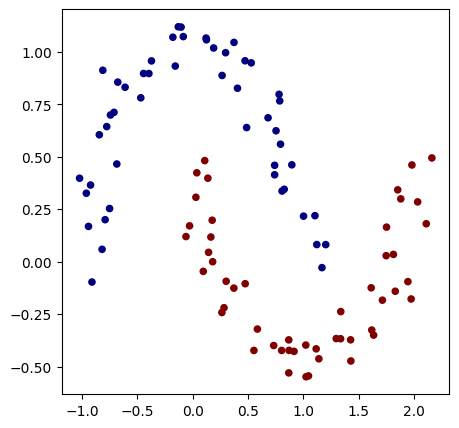

In [11]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [12]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer 'l0' of [ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2), ReLuNeuron(2)], Layer 'l1' of [ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16), ReLuNeuron(16)], Layer 'l2' of [LinearNeuron(16)]]
number of parameters 337


In [13]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

+:(data=1.20754, grad=0.00000) 0.5


In [14]:
# optimization
steps = 1000

def sgn(value:float):
    if value >= 0:
        return 1.   
    return -1.


for p in model.parameters():
    p.last_grad = 0

last_local_learning_rate = 1

class PController:
    def __init__(self, setpoint, kp):
        print(f"PController setpoint is {setpoint}")
        self.setpoint = setpoint  # Desired setpoint
        self.kp = kp              # Proportional gain

    def compute(self, feedback):
        error = self.setpoint - feedback
        control_signal = self.kp * error
        return control_signal
    
num_features = len(model.parameters())
    
params = np.random.randn(num_features)
gradients = np.random.randn(num_features)
m = np.zeros(num_features)
v = np.zeros(num_features)
    
def adam_optimizer(params, gradients, m, v, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = beta1 * m + (1 - beta1) * gradients
    v = beta2 * v + (1 - beta2) * (gradients ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    
    params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
    
    return params, m, v
    
pcontroller = PController(len(model.parameters()) * 0.1,.001)


for k in range(steps):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/steps
    max_grad = 0
    num_sgn_switches = 0
    ps = model.parameters()
    for i in range(len(ps)):
        params[i] = ps[i].data
        gradients[i] = ps[i].grad

    params, m, v = adam_optimizer(params, gradients, m, v, k+1)

    for i in range(len(ps)):
        ps[i].data = params[i]
        ps[i].grad = gradients[i]

    for p in model.parameters():
        max_grad = max(max_grad,abs(p.grad))
        sgn_switch = sgn(p.grad) != sgn(p.last_grad)
        num_sgn_switches += sgn_switch
        p.last_grad = p.grad

    if acc >= 1.:
        break
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc:.2%}%, max grad {max_grad}, sgn switches {num_sgn_switches}")


PController setpoint is 33.7
step 0 loss 1.2075389555362073, accuracy 50.00%%, max grad 1.1158961258518683, sgn switches 140
step 1 loss 0.9879335335169106, accuracy 51.00%%, max grad 1.0693030420457095, sgn switches 3
step 2 loss 0.7739517394334328, accuracy 60.00%%, max grad 0.9602946794569134, sgn switches 24
step 3 loss 0.6150176464568933, accuracy 71.00%%, max grad 0.4645336350649726, sgn switches 73
step 4 loss 0.5379684733132237, accuracy 83.00%%, max grad 0.4156727542807822, sgn switches 50
step 5 loss 0.49694647878067166, accuracy 84.00%%, max grad 0.39694423643721777, sgn switches 34
step 6 loss 0.478478475318463, accuracy 87.00%%, max grad 0.5750748215911875, sgn switches 53
step 7 loss 0.46176522624183103, accuracy 82.00%%, max grad 0.6320622685121159, sgn switches 35
step 8 loss 0.43438531259041074, accuracy 83.00%%, max grad 0.6446650142015847, sgn switches 19
step 9 loss 0.39920627926559665, accuracy 84.00%%, max grad 0.5084483794584801, sgn switches 1
step 10 loss 0.363

KeyboardInterrupt: 

The following value seems high: 10.32567131183579


(-1.548639298268643, 1.951360701731357)

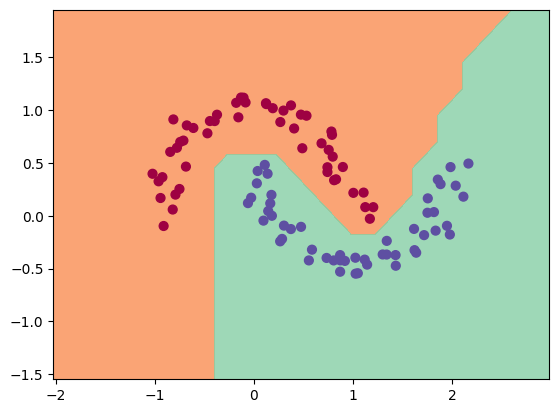

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
